In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io import fits

import sirtipy
import RPproject as rpp
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import numpy as np

### FITs Spectra

In [3]:
hdul = fits.open('ceers-lr-v1_prism-clear_1345_2759.spec.fits')
data = hdul[1].data
h1 = hdul[1].header 

FileNotFoundError: [Errno 2] No such file or directory: 'ceers-lr-v1_prism-clear_1345_2759.spec.fits'

In [4]:
obj_name = h1.get('OBJECT', 'Unknown')

flux = [f for _,f,_ in data]
w = WCS(h1, naxis=1, relax=False, fix=False)
lam = w.wcs_pix2world(np.arange(len(flux)), 0)[0]
wavmicron = lam/10000
z = 3.12
fJ = np.array(flux)*(1e-9)
fA = fJ*3e-5/(lam**2)

plt.plot(wavmicron*(z+1), fA,'o', label = "3D-EGS-31322")
# plt.ylim(0, )
# plt.xlim(7,15)
plt.legend()
plt.xlabel('Wavelength (Microns)')
plt.ylabel('Flux (ergs/s/cm^2/A)')
plt.savefig(obj_name + '.png')

NameError: name 'h1' is not defined

### Working on fit

#### first try

In [2]:
# Assume constant absorption
def alpha_constant(frequency, location, Inu, alpha_val):
    return alpha_val

# Blackbody thermal emission from experiment 2
def j_thermal(frequency, location, Inu, temperature, alphafunc, alphafunc_args):
    B = sirtipy.blackbody_intensity(temperature, frequency)
    alpha = alphafunc(frequency, location, Inu, *alphafunc_args)
    return alpha*B

In [3]:
freqaxis = sirtipy.frequency_axis('log', frange=[1.*u.cm, 1e-5*u.cm])
faxis = np.geomspace(np.min(freqaxis.frequencies), np.max(freqaxis.frequencies), 100)

tstart = 0.7e9 # How many years before the light was emitted that star formation started
tstop  = 0.3e9 # How many years before the light was emtited that star formation ended
  

I_initial = rpp.generate_blackbody(faxis, tstart, tstop, rpp.exp_SFR)
I_no_balmer = rpp.generate_blackbody(faxis, tstart, tstop, rpp.exp_SFR, balmer=False)
star_spectrum = [np.interp(f, faxis, I_initial) for f in freqaxis.frequencies]

In [4]:
def make_sed(height, medium_temp, alpha_0, coeff):
        medium = sirtipy.region()
        medium.add_emission_func(j_thermal, (medium_temp, alpha_constant, (alpha_0,)))
        medium.add_absorption_func(alpha_constant, (alpha_0,))

        s = [0, int(height.to(u.cm).value)]
        ds = int(height.to(u.cm).value/500)
        Inu = [coeff*s for s in star_spectrum]
        inspec = sirtipy.spectrum('verbatim', frequencies=freqaxis, intensities=Inu)
        spec, tau, locations = sirtipy.radiative_transfer(medium, inspec, s, ds, printevery=50)
        return spec, tau, locations

In [6]:
coeff = 0.5e-10
medium_temp = 800
alpha_0 = 0.85e-21
height = 200*u.pc


# make_sed will be the function we try to fit
spec, tau, locations = make_sed(height, medium_temp, alpha_0, coeff)

Location 50 of 500
Location 100 of 500
Location 150 of 500
Location 200 of 500
Location 250 of 500
Location 300 of 500
Location 350 of 500
Location 400 of 500
Location 450 of 500
Location 500 of 500


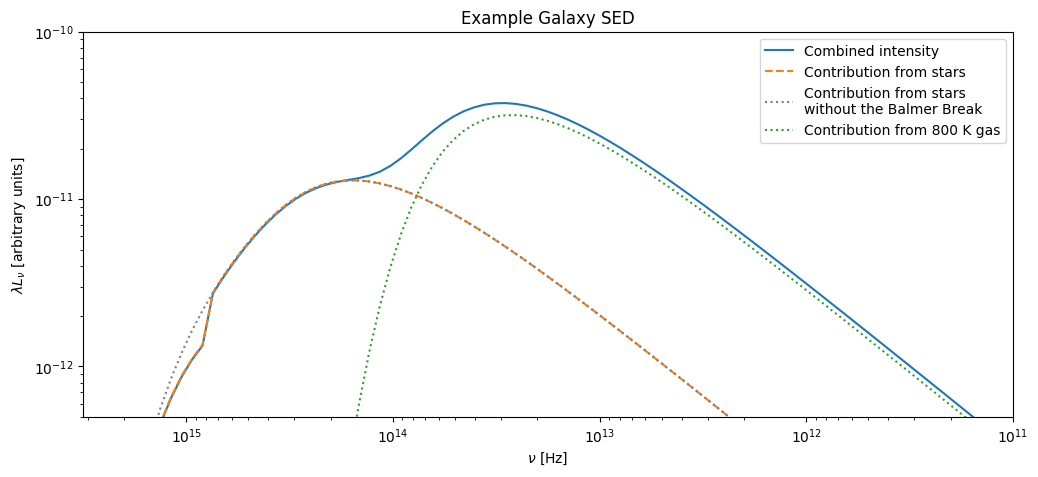

In [17]:
no_balmer_spec = [coeff*np.interp(f, faxis, I_no_balmer) for f in freqaxis.frequencies]
Inu = [s*const.c.cgs.value/f for f,s in zip(freqaxis.frequencies, spec[-1].intensity)]
stars = [3e-11*s*const.c.cgs.value/f for f,s in zip(freqaxis.frequencies, star_spectrum)]
gas = [0.4*const.c.cgs.value/f * sirtipy.blackbody_intensity(medium_temp,f) for f in freqaxis.frequencies]
nob = [0.6*const.c.cgs.value/f * s for f,s in zip(freqaxis.frequencies, no_balmer_spec)]
plt.figure(figsize=(12,5))
plt.plot(freqaxis.frequencies, Inu, label='Combined intensity')
plt.plot(freqaxis.frequencies, stars, linestyle='--', label='Contribution from stars')
plt.plot(freqaxis.frequencies, nob, linestyle=':',c='grey', label='Contribution from stars\nwithout the Balmer Break')
plt.plot(freqaxis.frequencies, gas, linestyle=':', label='Contribution from 800 K gas')

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim(10**15.5,10**11)
plt.ylim(0.5*10**-12, 10**-10)

plt.ylabel(r'$\lambda L_\nu$ [arbitrary units]')
plt.xlabel(r'$\nu$ [Hz]')
plt.title('Example Galaxy SED')
#plt.savefig('examplesed.png')
plt.show()

A quick attempt at adding special lines

In [8]:
from scipy.special import voigt_profile as voight
from astropy.modeling.models import Voigt1D

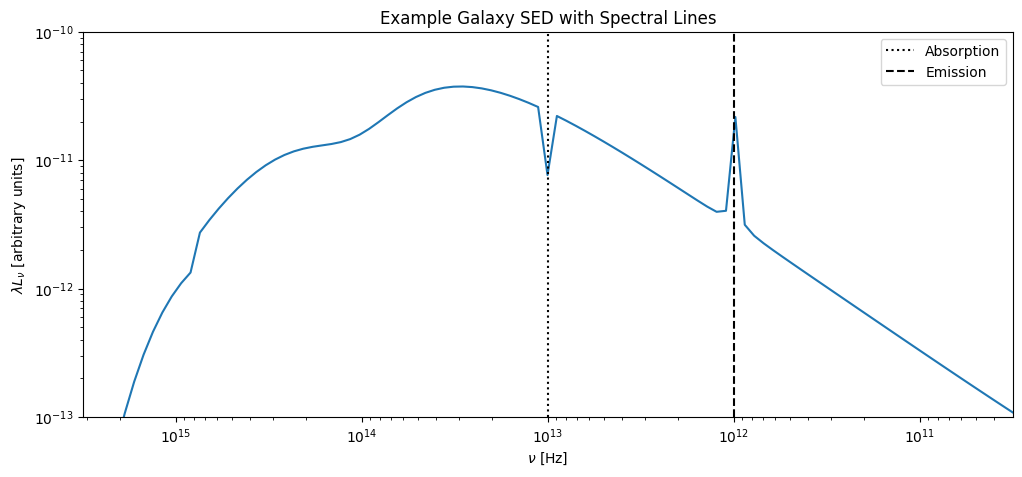

In [12]:
absorption_line = Voigt1D(1e13,0.1,0.1,0.1)
emission_line = Voigt1D(1e12,0.1,0.05,0.1)
Inu_plus_lines = [(const.c.cgs.value/f)*s + -1.5e14*absorption_line(f) + 1e14*emission_line(f) for f,s in zip(freqaxis.frequencies, spec[-1].intensity)]
plt.figure(figsize=(12,5))
plt.plot(freqaxis.frequencies, Inu_plus_lines)
plt.axvline(1e13, label='Absorption', c='k', linestyle=':')
plt.axvline(1e12, label='Emission', c='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlim(10**15.5,10**10.5)
plt.ylim(10**-13, 10**-10)

plt.ylabel(r'$\lambda L_\nu$ [arbitrary units]')
plt.xlabel(r'$\nu$ [Hz]')
plt.title('Example Galaxy SED with Spectral Lines')
#plt.savefig('examplesed.png')
plt.show()

Next, we should plot them together and try to eyeball to get a rough fit. We'll need to plug in the right star formation times etc as well.

In [1]:
frequency = const.c.to(u.micron/u.s).value/wavmicron

NameError: name 'const' is not defined

Then we try to fit.

In [101]:
from scipy.optimize import curve_fit

In [103]:
# This function will let us interpolate the make_sed function, to make it easier to fit
def sed(freq, params):
    height = params[0] # distance of medium in front of stars
    medium_temp = params[1]
    alpha_0 = params[2]
    coeff = params[3] # Scale factor for stellar component
    
    spec, _, _ = make_sed(height, medium_temp, alpha_0, coeff)
    return np.iterp(freq, freqaxis.frequencies, spec[-1].intensity)

In [ ]:
# FIXME

height_guess = 200*u.pc
temp_guess = ???
alpha_guess = ???
coeff_guess = ???
frequency = # wavmicron -> freq in Hz
initial_guesses = [height, temp_guess, alpha_guess, coeff_guess]
results = curve_fit(sed, frequency, fA, initial_guesses)